In [1]:
import finnhub
import requests
import pandas as pd
from datetime import datetime
from datetime import timezone
import matplotlib.pyplot as plt
import numpy as np
import math

import mplfinance as mpf
from mplfinance.original_flavor import candlestick_ohlc
import matplotlib.dates as mpl_dates

In [2]:
api_key1 = '8a1cf9d14d53126b05c8a7636fe3d006'
SP = requests.get(f'https://financialmodelingprep.com/api/v3/sp500_constituent?&apikey={api_key1}').json()    
SP = pd.DataFrame(SP)
sp = SP['symbol'].values.tolist()

api_key1 = '8a1cf9d14d53126b05c8a7636fe3d006'
NASDAQ = requests.get(f'https://financialmodelingprep.com/api/v3/nasdaq_constituent?&apikey={api_key1}').json()
NASDAQ = pd.DataFrame(NASDAQ)
nasdaq = NASDAQ['symbol'].values.tolist()

DJI = requests.get('https://finnhub.io/api/v1/index/constituents?symbol=^DJI&token=bt3efpf48v6tfcs816eg').json()
dji = DJI['constituents']

tickers = sp + nasdaq + dji
tickers = np.array(tickers)
tickers = np.unique(tickers)

In [3]:
# stock moving average
def SMA(close, n):
    sma = close.rolling(window = n).mean()
    return sma

# bounds
def Bollinger(close, sma, n, m):
    std = close.rolling(window = n).std()
    BOLU = sma + std * m
    BOLD = sma - std * m
    return BOLU, BOLD

def Keltner(sma, tr, n, m):
    atr = tr.rolling(window = n).mean()
    KCU = sma + atr * m
    KCD = sma - atr * m
    return KCU, KCD

def in_squeeze(data):
    return data['bold'] > data['kcd'] and data['bolu'] < data['kcu']

def Dochain_midline(high, low, n):
    h = high.rolling(window = n).max()
    l = low.rolling(window = n).min()
    mid = (h + l)/2
    return mid

def delta(close, mid, sma):
    return close - ((mid + sma) / 2)  

def MACD(close):
    ema12 = close.ewm(span = 12).mean()
    ema26 = close.ewm(span = 26).mean()
    return ema12 - ema26

def MACD_signal(macd):
    return macd.ewm(span = 9).mean()

def MACD_hist(macd, macd_signal):
    return macd - macd_signal

In [4]:
# Setup client
api_key = "bt3efpf48v6tfcs816eg"
finnhub_client = finnhub.Client(api_key)

# Stock candles
ticker = 'TSLA'
start_time = int(datetime(2020, 12, 1, 0, 0).replace(tzinfo = timezone.utc).timestamp())
end_time = int(datetime(2021, 7, 1, 0, 0).replace(tzinfo = timezone.utc).timestamp())
res = finnhub_client.stock_candles(ticker, 'D', start_time, end_time)

stock = pd.DataFrame(res)
stock = stock.rename(columns = {'t':'Date', 'o':'open', 'h':'high', 'l':'low', 'c':'close', 's':'status', 'v':'volumn'})
stock['Date'] = pd.to_datetime(stock['Date'], unit = 's')
stock = stock.set_index('Date')

stock['sma'] = SMA(stock['close'], 20) # simple moving average
stock['tr'] = abs(stock['high'] - stock['low']) # true range
stock['bolu'], stock['bold'] = Bollinger(stock['close'], stock['sma'], 20, 2)
stock['kcu'], stock['kcd'] = Keltner(stock['sma'], stock['tr'], 20, 1.5)

stock = stock.dropna()
stock['squeeze_on'] = stock.apply(in_squeeze, axis = 1)
son = stock.loc[((stock['squeeze_on']) & (stock['volumn'] >= 1e6)),:].index
soff = stock.loc[((~stock['squeeze_on']) & (stock['volumn'] >= 1e6)),:].index

In [5]:
stock['dochain_mid'] = Dochain_midline(stock.high, stock.low, 20)
stock['delta'] = delta(stock.close, stock.dochain_mid, stock.sma)
stock = stock.dropna()

In [13]:
from sklearn.linear_model import LinearRegression
import statsmodels.formula.api as smf

test = smf.ols(formula = 'delta ~ dochain_mid + sma + close', data = stock).fit()
test.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  delta   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 8.728e+29
Date:                Thu, 08 Jul 2021   Prob (F-statistic):               0.00
Time:                        10:51:23   Log-Likelihood:                 2984.2
No. Observations:                 109   AIC:                            -5960.
Df Residuals:                     105   BIC:                            -5950.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept   -1.279e-13   2.98e-13     -0.430      0.668   -7.18e-13    4.62e-13
dochain_mid    -0.5000   2.22e-15  -2.25e+14      0.000      -0.500      -0.500
sma            -0.5000   1.92e-15   -2.6e+14      0.000      -0.500      -0.500
close           1.0000   6.69e-16    1.5e+15      0.000       1.000       1.000
==============================================================================
Omnibus:                        4.111   Durbin-Watson:                   0.033
Prob(Omnibus):                  0.128   Jarque-Bera (JB):                2.480
Skew:                           0.145   Prob(JB):                        0.289
Kurtosis:                       2.320   Cond. No.                     1.18e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.18e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [14]:
stock['delta_pred'] = test.predict(stock[['close', 'sma', 'dochain_mid']])

In [19]:
above_up_d = []
above_down_d = []
below_up_d = []
below_down_d = []

if stock.iloc[0]['delta_pred'] > 0:
    if stock.iloc[0]['delta_pred'] < stock.iloc[1]['delta_pred']:
        above_up_d.append(stock.index[0])
    else:
        above_down_d.append(stock.index[0])
if stock.iloc[0]['delta_pred'] < 0:
    if stock.iloc[0]['delta_pred'] < stock.iloc[1]['delta_pred']:
        below_up_d.append(stock.index[0])
    else:
        below_down_d.append(stock.index[0])
    
for i in range(1, stock.shape[0]):
    if stock.iloc[i]['delta_pred'] > 0:
        if stock.iloc[i]['delta_pred'] > stock.iloc[i - 1]['delta_pred']:
            above_up_d.append(stock.index[i])
        else:
            above_down_d.append(stock.index[i])
    if stock.iloc[i]['delta_pred'] < 0:
        if stock.iloc[i]['delta_pred'] > stock.iloc[i - 1]['delta_pred']:
            below_up_d.append(stock.index[i])
        else:
            below_down_d.append(stock.index[i])

In [7]:
stock['macd'] = MACD(stock['close'])
stock['macd_signal'] = MACD_signal(stock.macd)
stock['macd_hist'] = MACD_hist(stock.macd, stock.macd_signal)

In [8]:
above_up = []
above_down = []
below_up = []
below_down = []

if stock.iloc[0]['macd_hist'] > 0:
    if stock.iloc[0]['macd_hist'] < stock.iloc[1]['macd_hist']:
        above_up.append(stock.index[0])
    else:
        above_down.append(stock.index[0])
if stock.iloc[0]['macd_hist'] < 0:
    if stock.iloc[0]['macd_hist'] < stock.iloc[1]['macd_hist']:
        below_up.append(stock.index[0])
    else:
        below_down.append(stock.index[0])
    
for i in range(1, stock.shape[0]):
    if stock.iloc[i]['macd_hist'] > 0:
        if stock.iloc[i]['macd_hist'] > stock.iloc[i - 1]['macd_hist']:
            above_up.append(stock.index[i])
        else:
            above_down.append(stock.index[i])
    if stock.iloc[i]['macd_hist'] < 0:
        if stock.iloc[i]['macd_hist'] > stock.iloc[i - 1]['macd_hist']:
            below_up.append(stock.index[i])
        else:
            below_down.append(stock.index[i])

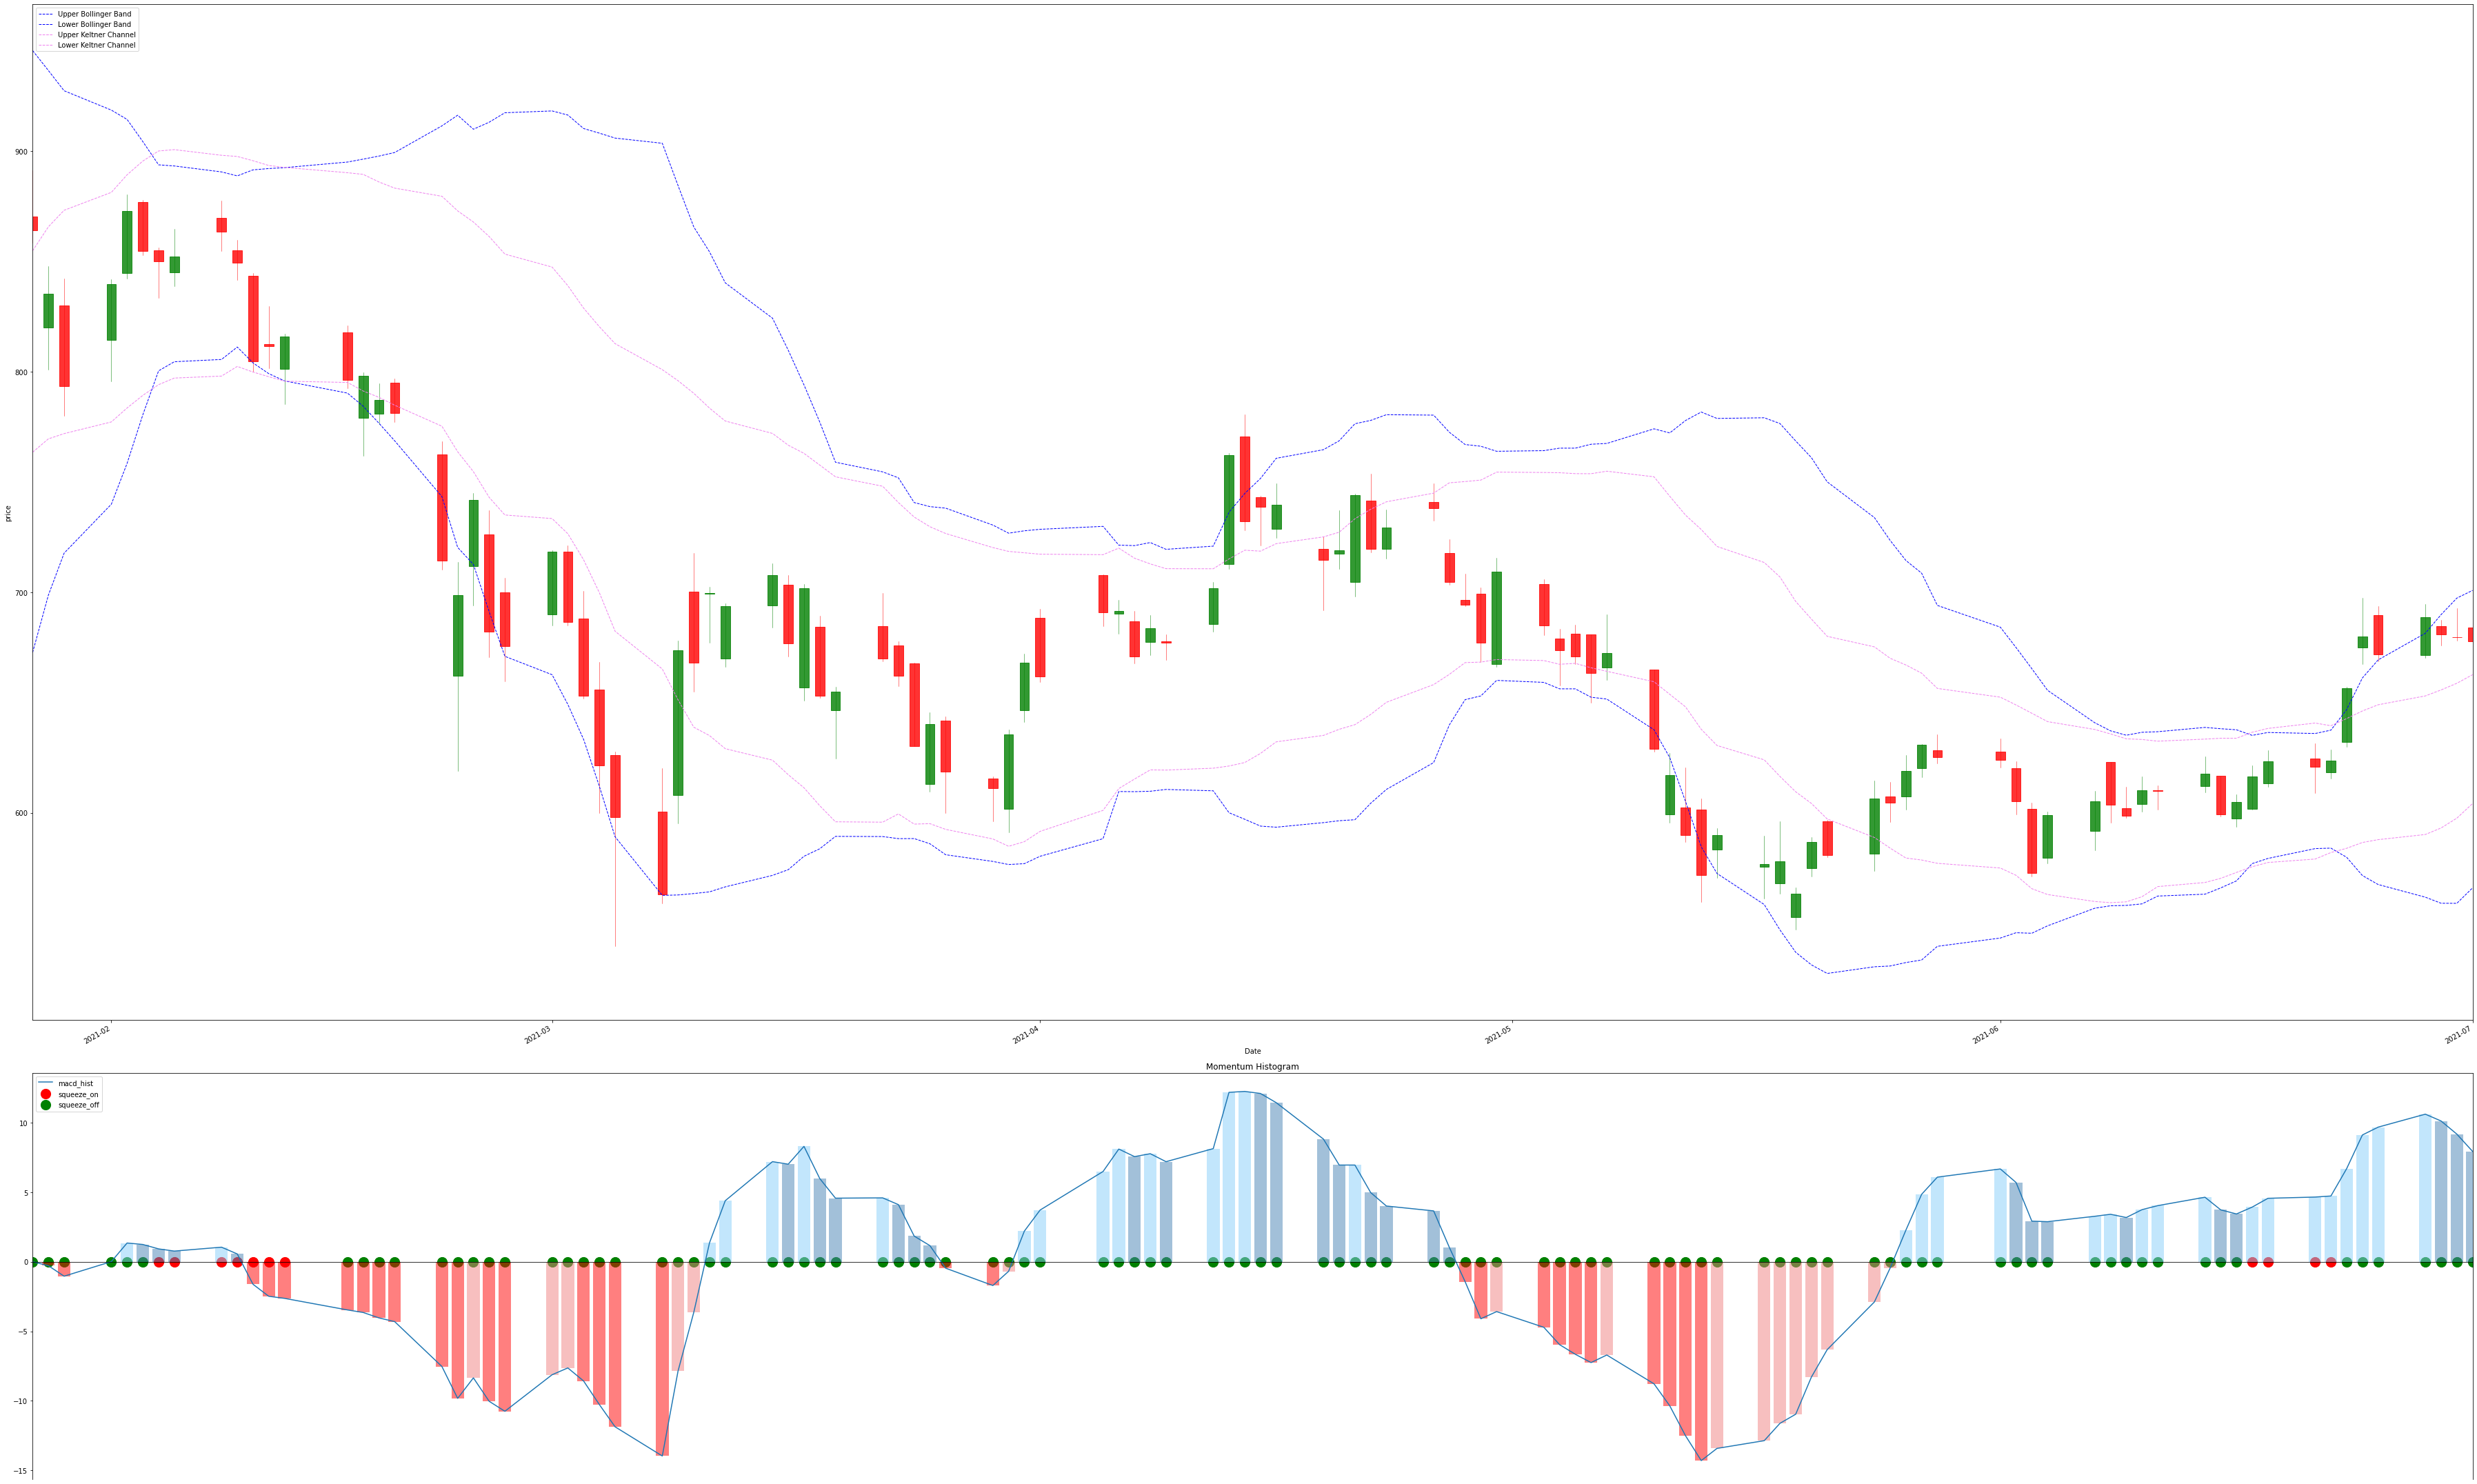

In [29]:
plt.rcParams['axes.xmargin'] = 0
plt.rcParams['figure.figsize'] = (50, 30)
fig, axs = plt.subplots(2, gridspec_kw={'height_ratios': [5, 2]})

plt.setp(axs, xlim=[stock.index[0], stock.index[-1]])

stock['Date'] = pd.to_datetime(stock.index)
stock['Date'] = stock['Date'].apply(mpl_dates.date2num)
stock_candle = stock.loc[:,['Date', 'open', 'high', 'low', 'close']]

candlestick_ohlc(axs[0], stock_candle.values, width=0.6,\
                 colorup='green', colordown='red', alpha=0.8)
stock['bolu'].plot(label = 'Upper Bollinger Band', linestyle = '--', linewidth = 1,\
                   color = 'blue', ax = axs[0])
stock['bold'].plot(label = 'Lower Bollinger Band', linestyle = '--', linewidth = 1,\
                   color = 'blue', ax = axs[0])
stock['kcu'].plot(label = 'Upper Keltner Channel', linestyle = '--', linewidth = 1,\
                  color = 'violet', ax = axs[0])
stock['kcd'].plot(label = 'Lower Keltner Channel', linestyle = '--', linewidth = 1,\
                  color = 'violet', ax = axs[0])
axs[1].spines['bottom'].set_position('zero')
axs[1].scatter(x = son, y = [0] * len(son), s = 200, c = 'red', label = 'squeeze_on')
axs[1].scatter(x = soff, y = [0] * len(soff), s = 200, c = 'green', label = 'squeeze_off')
stock['macd_hist'].plot(ax = axs[1])
axs[1].bar(x = above_up, height = stock.loc[above_up, 'macd_hist'],\
           width = 0.8, alpha = 0.5, color = 'lightskyblue')
axs[1].bar(x = above_down, height = stock.loc[above_down, 'macd_hist'],\
           width = 0.8, alpha = 0.5, color = 'steelblue')
axs[1].bar(x = below_up, height = stock.loc[below_up, 'macd_hist'],\
           width = 0.8, alpha = 0.5, color = 'lightcoral')
axs[1].bar(x = below_down, height = stock.loc[below_down, 'macd_hist'],\
           width = 0.8, alpha = 0.5, color = 'red')
#stock['macd_hist'].plot.bar(label = 'Momentum hist', width = 0.2, ax = axs[1])

axs[1].set_xticks([])
axs[1].set(xlabel = '', ylabel = '')
axs[1].title.set_text('Momentum Histogram')
axs[1].legend(loc = 'upper left')
axs[0].set(xlabel = 'Date', ylabel = 'price')
axs[0].legend(loc = 'upper left')
plt.tight_layout()
plt.savefig('squeeze.jpg')
plt.show()

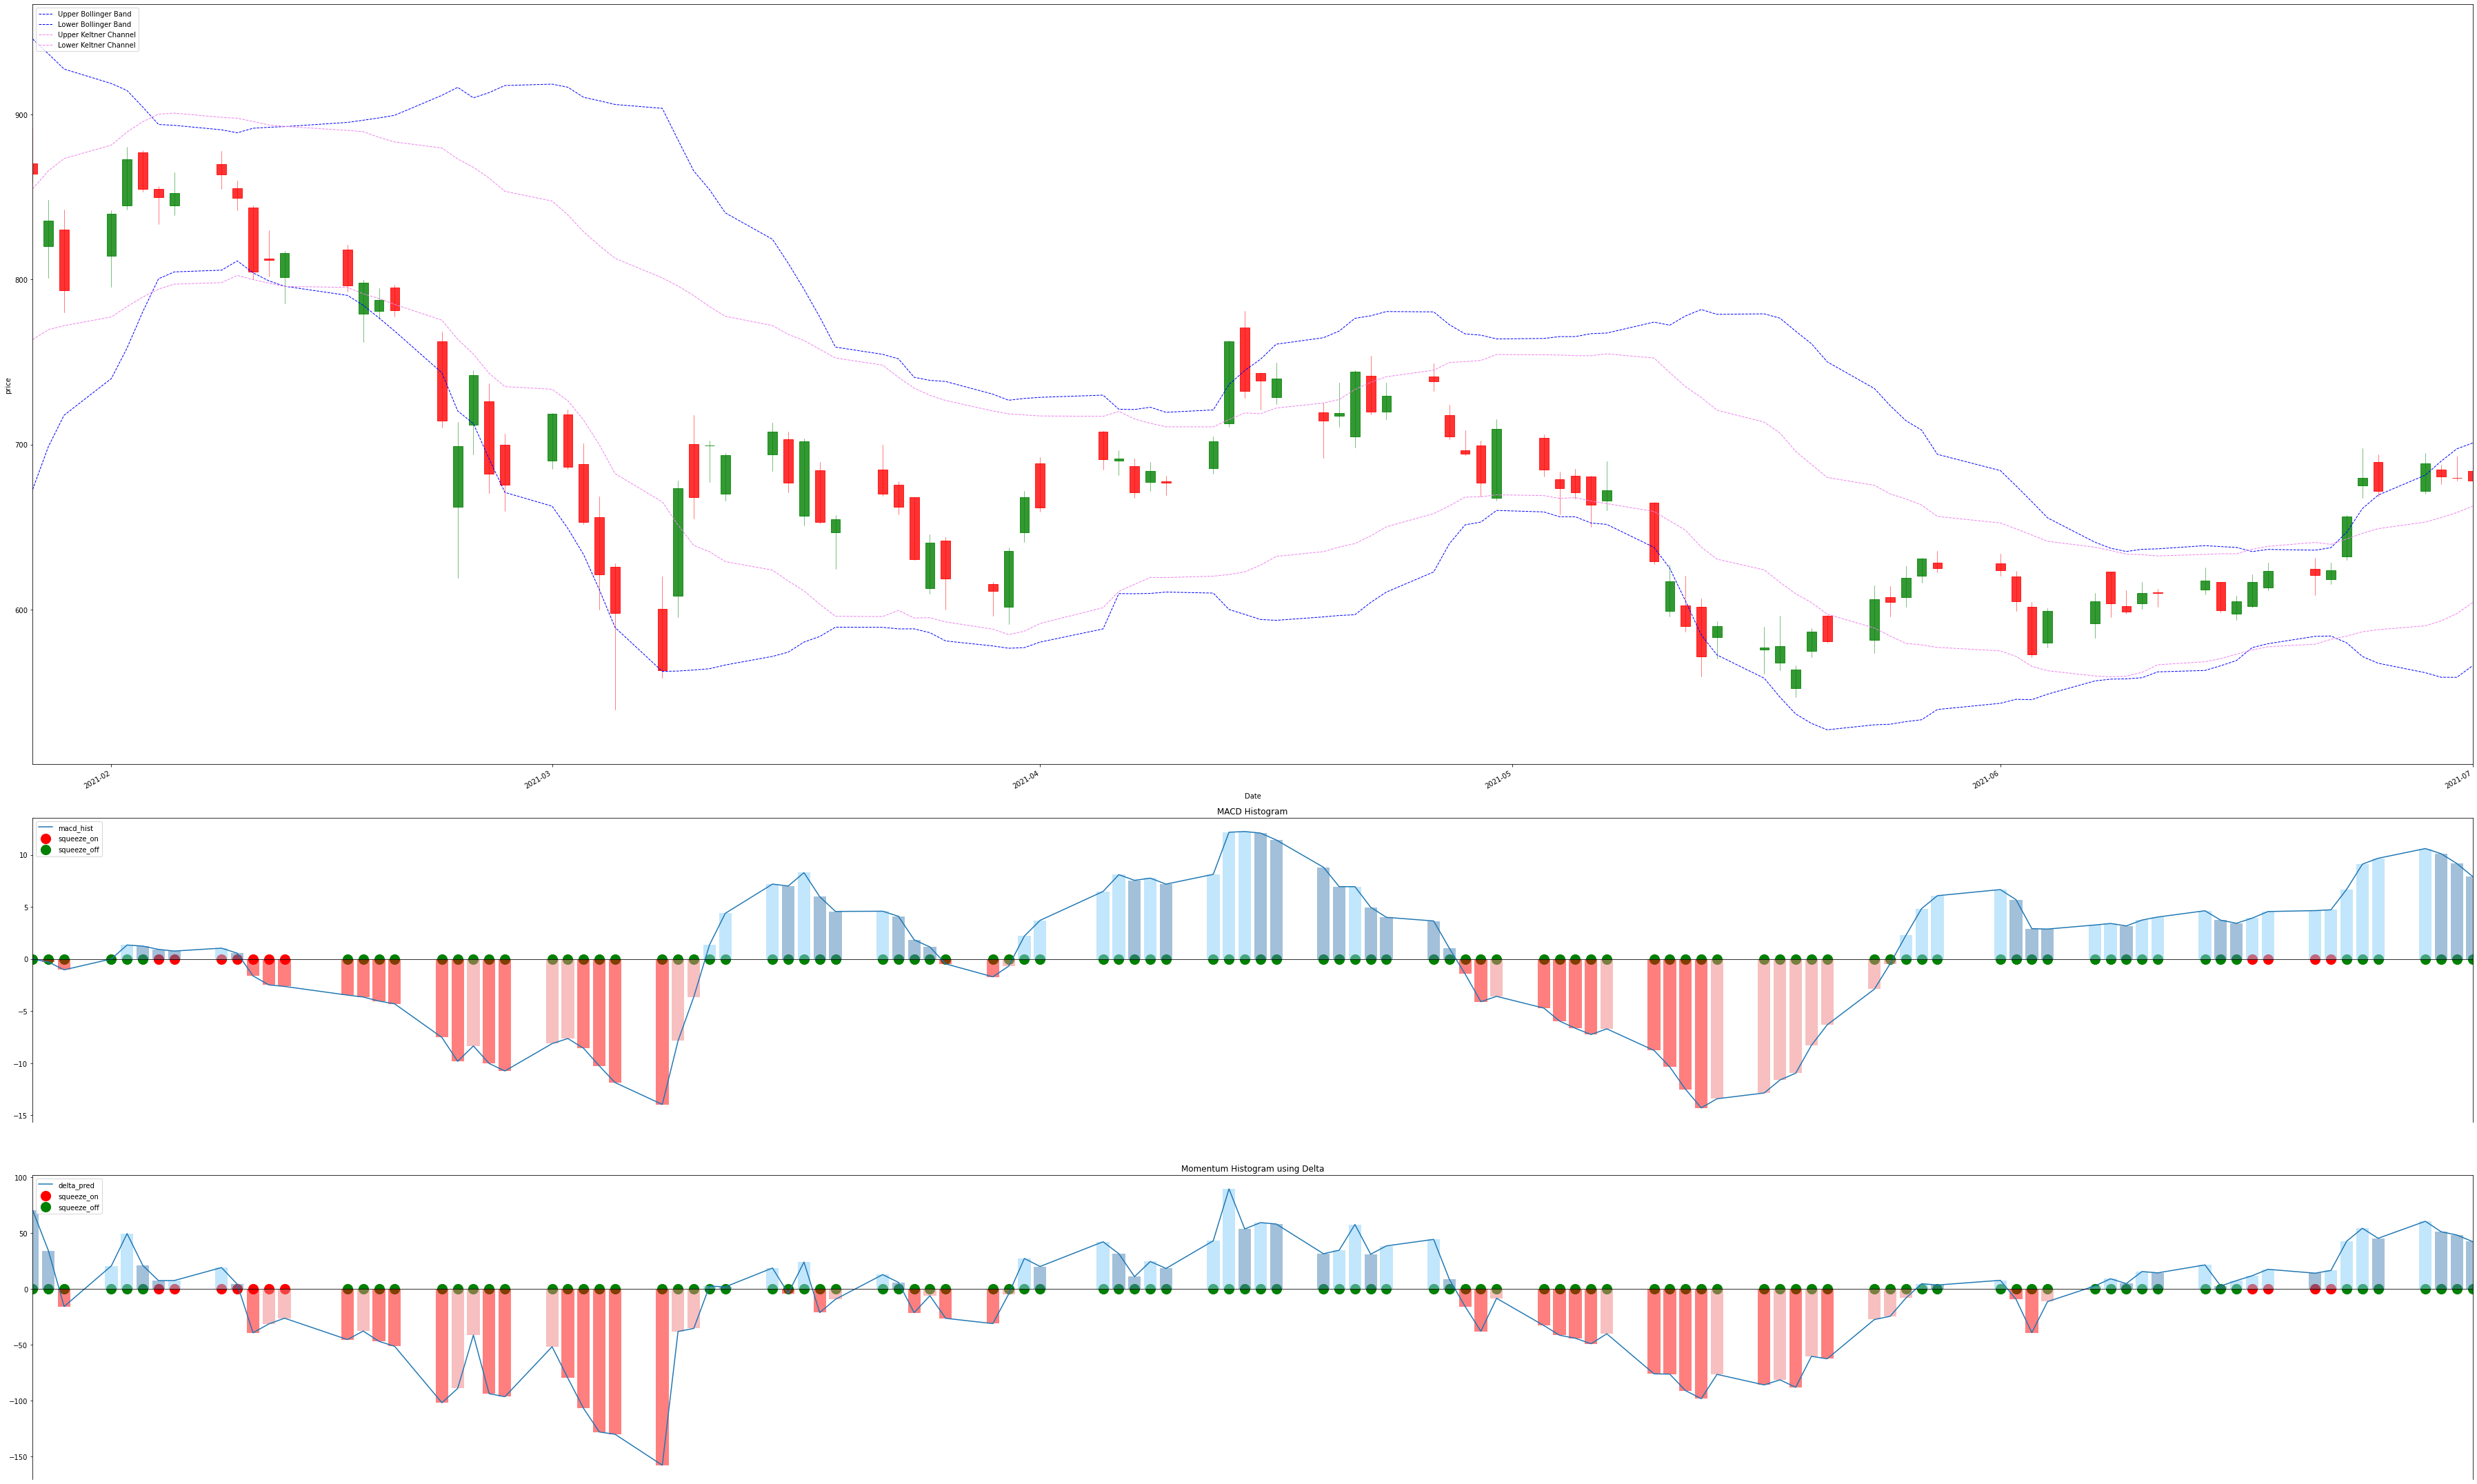

In [30]:
plt.rcParams['axes.xmargin'] = 0
plt.rcParams['figure.figsize'] = (50, 30)
fig, axs = plt.subplots(3, gridspec_kw={'height_ratios': [5, 2, 2]})

plt.setp(axs, xlim=[stock.index[0], stock.index[-1]])

stock['Date'] = pd.to_datetime(stock.index)
stock['Date'] = stock['Date'].apply(mpl_dates.date2num)
stock_candle = stock.loc[:,['Date', 'open', 'high', 'low', 'close']]

candlestick_ohlc(axs[0], stock_candle.values, width=0.6,\
                 colorup='green', colordown='red', alpha=0.8)
stock['bolu'].plot(label = 'Upper Bollinger Band', linestyle = '--', linewidth = 1,\
                   color = 'blue', ax = axs[0])
stock['bold'].plot(label = 'Lower Bollinger Band', linestyle = '--', linewidth = 1,\
                   color = 'blue', ax = axs[0])
stock['kcu'].plot(label = 'Upper Keltner Channel', linestyle = '--', linewidth = 1,\
                  color = 'violet', ax = axs[0])
stock['kcd'].plot(label = 'Lower Keltner Channel', linestyle = '--', linewidth = 1,\
                  color = 'violet', ax = axs[0])

axs[1].spines['bottom'].set_position('zero')
axs[1].scatter(x = son, y = [0] * len(son), s = 200, c = 'red', label = 'squeeze_on')
axs[1].scatter(x = soff, y = [0] * len(soff), s = 200, c = 'green', label = 'squeeze_off')
stock['macd_hist'].plot(ax = axs[1])
axs[1].bar(x = above_up, height = stock.loc[above_up, 'macd_hist'],\
           width = 0.8, alpha = 0.5, color = 'lightskyblue')
axs[1].bar(x = above_down, height = stock.loc[above_down, 'macd_hist'],\
           width = 0.8, alpha = 0.5, color = 'steelblue')
axs[1].bar(x = below_up, height = stock.loc[below_up, 'macd_hist'],\
           width = 0.8, alpha = 0.5, color = 'lightcoral')
axs[1].bar(x = below_down, height = stock.loc[below_down, 'macd_hist'],\
           width = 0.8, alpha = 0.5, color = 'red')

axs[2].spines['bottom'].set_position('zero')
axs[2].scatter(x = son, y = [0] * len(son), s = 200, c = 'red', label = 'squeeze_on')
axs[2].scatter(x = soff, y = [0] * len(soff), s = 200, c = 'green', label = 'squeeze_off')
stock['delta_pred'].plot(ax = axs[2])
axs[2].bar(x = above_up_d, height = stock.loc[above_up_d, 'delta_pred'],\
           width = 0.8, alpha = 0.5, color = 'lightskyblue')
axs[2].bar(x = above_down_d, height = stock.loc[above_down_d, 'delta_pred'],\
           width = 0.8, alpha = 0.5, color = 'steelblue')
axs[2].bar(x = below_up_d, height = stock.loc[below_up_d, 'delta_pred'],\
           width = 0.8, alpha = 0.5, color = 'lightcoral')
axs[2].bar(x = below_down_d, height = stock.loc[below_down_d, 'delta_pred'],\
           width = 0.8, alpha = 0.5, color = 'red')


axs[0].set(xlabel = 'Date', ylabel = 'price')
axs[0].legend(loc = 'upper left')
axs[1].set_xticks([])
axs[1].set(xlabel = '', ylabel = '')
axs[1].legend(loc = 'upper left')
axs[2].set_xticks([])
axs[2].set(xlabel = '', ylabel = '')
axs[2].legend(loc = 'upper left')

axs[1].title.set_text('MACD Histogram')
axs[2].title.set_text('Momentum Histogram using Delta')
plt.tight_layout()
plt.savefig('squeeze_compare.jpg')
plt.show()

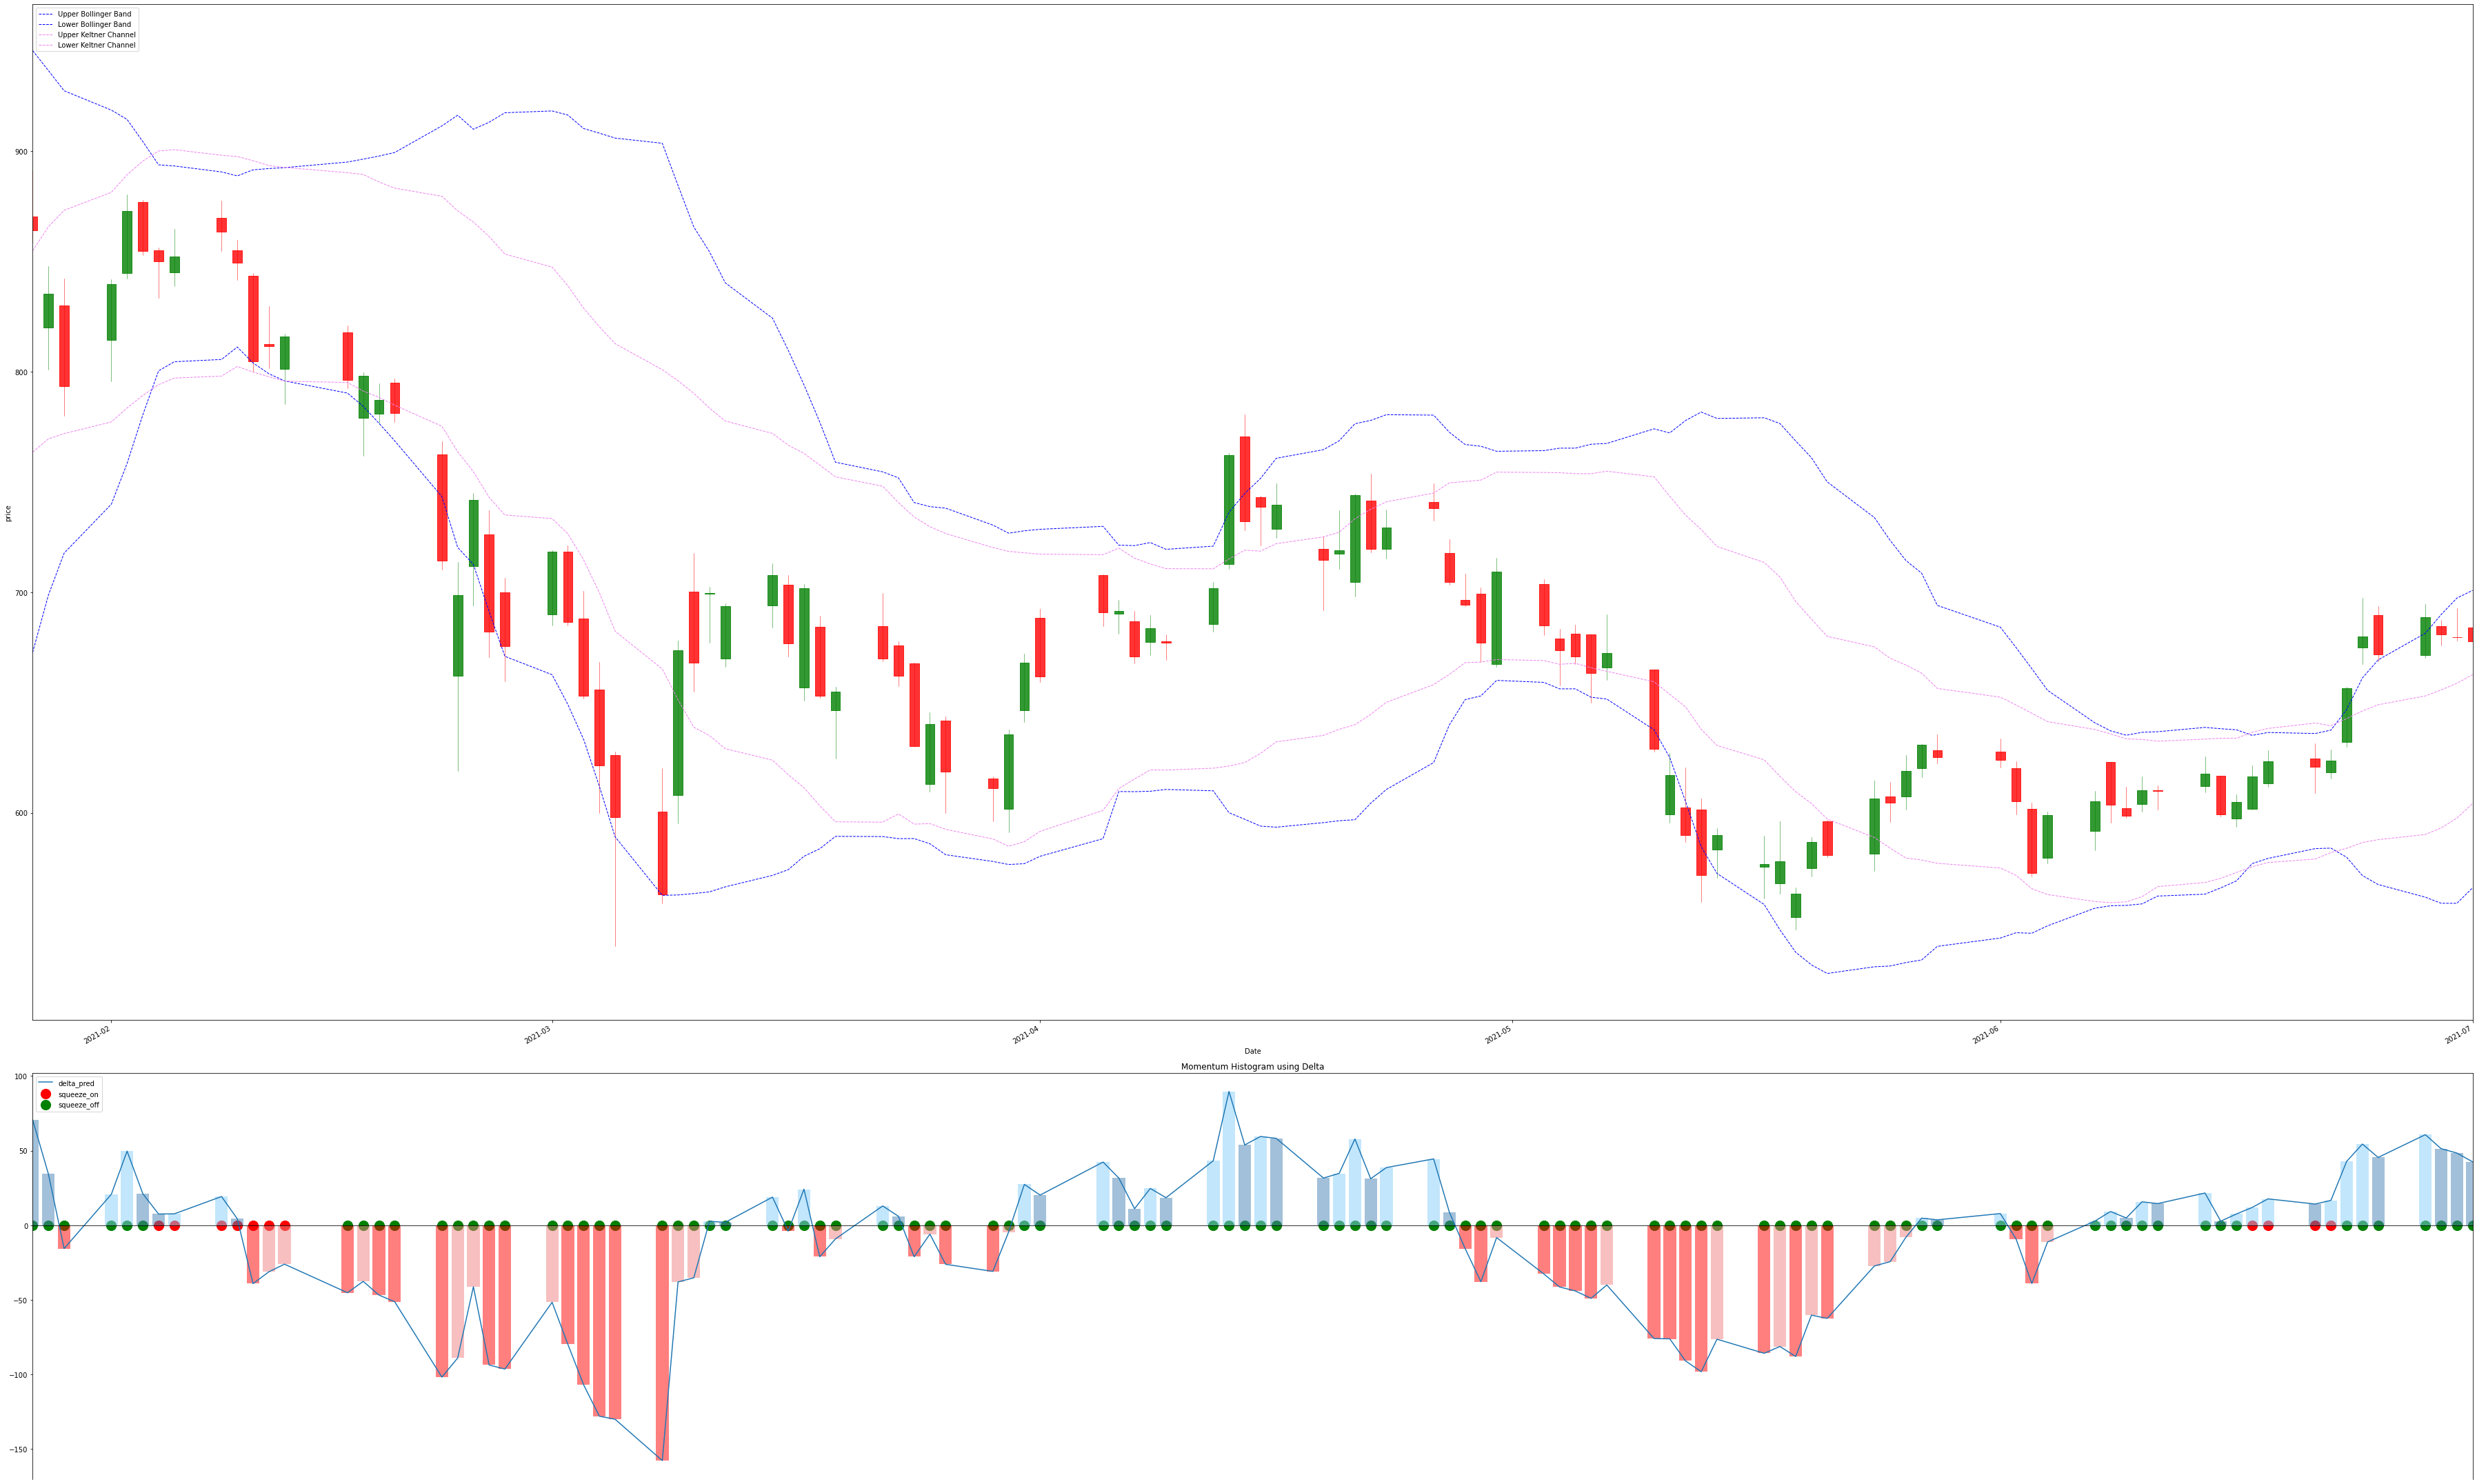

In [28]:
plt.rcParams['axes.xmargin'] = 0
plt.rcParams['figure.figsize'] = (50, 30)
fig, axs = plt.subplots(2, gridspec_kw={'height_ratios': [5, 2]})

plt.setp(axs, xlim=[stock.index[0], stock.index[-1]])

stock['Date'] = pd.to_datetime(stock.index)
stock['Date'] = stock['Date'].apply(mpl_dates.date2num)
stock_candle = stock.loc[:,['Date', 'open', 'high', 'low', 'close']]

candlestick_ohlc(axs[0], stock_candle.values, width=0.6,\
                 colorup='green', colordown='red', alpha=0.8)
stock['bolu'].plot(label = 'Upper Bollinger Band', linestyle = '--', linewidth = 1,\
                   color = 'blue', ax = axs[0])
stock['bold'].plot(label = 'Lower Bollinger Band', linestyle = '--', linewidth = 1,\
                   color = 'blue', ax = axs[0])
stock['kcu'].plot(label = 'Upper Keltner Channel', linestyle = '--', linewidth = 1,\
                  color = 'violet', ax = axs[0])
stock['kcd'].plot(label = 'Lower Keltner Channel', linestyle = '--', linewidth = 1,\
                  color = 'violet', ax = axs[0])

# axs[1].spines['bottom'].set_position('zero')
# axs[1].scatter(x = son, y = [0] * len(son), s = 200, c = 'red', label = 'squeeze_on')
# axs[1].scatter(x = soff, y = [0] * len(soff), s = 200, c = 'green', label = 'squeeze_off')
# stock['macd_hist'].plot(ax = axs[1])
# axs[1].bar(x = above_up, height = stock.loc[above_up, 'macd_hist'],\
#            width = 0.8, alpha = 0.5, color = 'lightskyblue')
# axs[1].bar(x = above_down, height = stock.loc[above_down, 'macd_hist'],\
#            width = 0.8, alpha = 0.5, color = 'steelblue')
# axs[1].bar(x = below_up, height = stock.loc[below_up, 'macd_hist'],\
#            width = 0.8, alpha = 0.5, color = 'lightcoral')
# axs[1].bar(x = below_down, height = stock.loc[below_down, 'macd_hist'],\
#            width = 0.8, alpha = 0.5, color = 'red')

axs[1].spines['bottom'].set_position('zero')
axs[1].scatter(x = son, y = [0] * len(son), s = 200, c = 'red', label = 'squeeze_on')
axs[1].scatter(x = soff, y = [0] * len(soff), s = 200, c = 'green', label = 'squeeze_off')
stock['delta_pred'].plot(ax = axs[1])
axs[1].bar(x = above_up_d, height = stock.loc[above_up_d, 'delta_pred'],\
           width = 0.8, alpha = 0.5, color = 'lightskyblue')
axs[1].bar(x = above_down_d, height = stock.loc[above_down_d, 'delta_pred'],\
           width = 0.8, alpha = 0.5, color = 'steelblue')
axs[1].bar(x = below_up_d, height = stock.loc[below_up_d, 'delta_pred'],\
           width = 0.8, alpha = 0.5, color = 'lightcoral')
axs[1].bar(x = below_down_d, height = stock.loc[below_down_d, 'delta_pred'],\
           width = 0.8, alpha = 0.5, color = 'red')


axs[0].set(xlabel = 'Date', ylabel = 'price')
axs[0].legend(loc = 'upper left')
axs[1].set_xticks([])
axs[1].set(xlabel = '', ylabel = '')
axs[1].legend(loc = 'upper left')

axs[1].title.set_text('Momentum Histogram using Delta')
plt.tight_layout()
plt.savefig('squeeze_momentum.jpg')
plt.show()

In [10]:
# import plotly.graph_objects as go

# def chart(df):
#     candlestick = go.Candlestick(x=df['Date'], open=df['open'], high=df['high'], low=df['low'], close=df['close'])
#     upper_band = go.Scatter(x=df['Date'], y=df['bolu'], name='Upper Bollinger Band', line={'color': 'red'})
#     lower_band = go.Scatter(x=df['Date'], y=df['bold'], name='Lower Bollinger Band', line={'color': 'red'})

#     upper_keltner = go.Scatter(x=df['Date'], y=df['kcu'], name='Upper Keltner Channel', line={'color': 'blue'})
#     lower_keltner = go.Scatter(x=df['Date'], y=df['kcd'], name='Lower Keltner Channel', line={'color': 'blue'})

#     fig = go.Figure(data=[candlestick, upper_band, lower_band, upper_keltner, lower_keltner])
#     fig.layout.xsaxis.type = 'category'
#     fig.layout.xaxis.rangeslider.visible = False
#     fig.show()

# chart(stock)

In [11]:
# ls = 0 # long signal
# long_entry = []
# long_exit = []
# stock['pos'] = 0 # long position
# for i in stock.index:
#     if (ls == 1) & (stock.loc[i, 'squeeze_on']):
#         ls = 0
#         long_exit.append(i)
#     if (ls == 0) & (~stock.loc[i, 'squeeze_on']):
#         ls = 1
#         long_entry.append(i)
#     stock.loc[i, 'pos'] = ls